# Preprocesamiento (crear datasets)

In [2]:
from utils import ls, preprocess_wav, melspectrogram, stft, normalize, linear_to_mel, amp_to_db
import numpy as np
from typing import Callable
from params import *
from librosa.util import normalize as HIFI_audio_normalize
import torch
import librosa

def custom_get_spec(wav, audio_preprocess: Callable, spec_process: Callable, spec_norm: Callable):
    # Preprocess the audio
    wav = audio_preprocess(wav)
    
    # Get the spectrogram
    spec = spec_process(wav)
    
    # Normalize the spectrogram
    spec = spec_norm(spec)
    
    return spec

def VAE_audio_preprocess(wav_path):
    return preprocess_wav(wav_path)

def VAE_spectrogram(y):
    D = stft(y)
    S = linear_to_mel(np.abs(D))
    return S

def VAE_spectrogram_normalize(S):
    S = amp_to_db(S)
    return normalize(S)

def HIFIGAN_audio_preprocess(wav_path):
    y, _ = librosa.load(wav_path, sr=sample_rate)
    y = HIFI_audio_normalize(y) * 0.95
    return y

def HIFIGAN_spectrogram(y):
    spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sample_rate, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length, 
        window='hann', 
        center=False, 
        pad_mode='reflect', 
        power=1.0,
        fmin=fmin, 
        fmax=fmax, 
        n_mels=num_mels
        )
    return spec

def HIFIGAN_spectrogram_normalize(spec):
    def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
        return torch.log(torch.clamp(x, min=clip_val) * C)
    
    def dynamic_range_compression(x, C=1, clip_val=1e-5):
        return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)
    
    def spectral_normalize_torch(magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output
    spec = spectral_normalize_torch(spec)
    return spec

In [ ]:
import pickle
from tqdm import tqdm
from params import num_samples
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os

DATA_SOURCE = r'data_source'
SPEAKERS = {0: 'mi_voz'}
DATASET_NAME = 'mi_voz'
DATASET_VERSION = 'v1'
DATASET_PATH = r'datasets\%s\%s' % (DATASET_NAME, DATASET_VERSION)
TEST_SIZE = 0.1
EVAL_SIZE = 0.1
N_SPKRS = len(SPEAKERS)
SPLIT = False

AUDIO_PREPROCESS = HIFIGAN_audio_preprocess
SPECTROGRAM_PROCESS = HIFIGAN_spectrogram
SPECTROGRAM_NORMALIZE = VAE_spectrogram_normalize

FEATURES = {
    'SPEAKERS': SPEAKERS,
    'TEST_SIZE': TEST_SIZE,
    'EVAL_SIZE': EVAL_SIZE,
    'N_SPKRS': N_SPKRS,
    'SPLIT': SPLIT,
    'DATA_SOURCE': DATA_SOURCE,
    'DATASET_PATH': DATASET_PATH,
    'AUDIO_PREPROCESS': AUDIO_PREPROCESS.__name__,
    'SPECTROGRAM_PROCESS': SPECTROGRAM_PROCESS.__name__,
    'SPECTROGRAM_NORMALIZE': SPECTROGRAM_NORMALIZE.__name__,
}

not_train_size = TEST_SIZE + EVAL_SIZE

REUSE_DIVISION = False

if os.path.exists(os.path.join(DATASET_PATH, 'refs_train.pickle')):
        REUSE_DIVISION = True
        train_refs = pickle.load(open('%s/refs_train.pickle' % (DATASET_PATH), 'rb'))
        eval_refs = pickle.load(open('%s/refs_eval.pickle' % (DATASET_PATH), 'rb'))
        test_refs = pickle.load(open('%s/refs_test.pickle' % (DATASET_PATH), 'rb'))
        print("Using existing train/eval/test references.")
else:
    train_refs = {}
    eval_refs = {}
    test_refs = {}

# Stores preprocessed spectrograms
train_feats = defaultdict(list)
eval_feats = defaultdict(list)
test_feats = defaultdict(list)


def get_spect(wav):
    return custom_get_spec('%s/%s/%s' % (DATA_SOURCE, SPEAKERS[spkr], wav),
                           audio_preprocess=AUDIO_PREPROCESS,
                           spec_process=SPECTROGRAM_PROCESS,
                           spec_norm=SPECTROGRAM_NORMALIZE)

for spkr in range(N_SPKRS):
    if not REUSE_DIVISION:
        # wavs = [f for f in os.listdir(os.path.join(DATA_SOURCE, SPEAKERS[spkr])) if f.endswith('.wav')]
        wavs = [f for f in os.listdir(os.path.join(DATA_SOURCE, SPEAKERS[spkr]))]
        
        if SPLIT:
            # Prepares reference filenames from train/eval/test split
            train_refs[spkr], temp_refs = train_test_split(wavs, test_size=(not_train_size), random_state=42)
            eval_refs[spkr], test_refs[spkr] = train_test_split(temp_refs, test_size=(TEST_SIZE/not_train_size), random_state=42)

    if SPLIT:
                        
        for wav in tqdm(train_refs[spkr], total=len(train_refs[spkr]), desc="spkr_%d_train"%(spkr+1)):
            spect = get_spect(wav)
            if spect.shape[1] >= num_samples: train_feats[spkr].append(spect)  
                
        for wav in tqdm(eval_refs[spkr], total=len(eval_refs[spkr]), desc="spkr_%d_eval"%(spkr+1)):
            spect = get_spect(wav)
            if spect.shape[1] >= num_samples: eval_feats[spkr].append(spect)
            
        for wav in tqdm(test_refs[spkr], total=len(test_refs[spkr]), desc="spkr_%d_test"%(spkr+1)):
            spect = get_spect(wav)
            if spect.shape[1] >= num_samples: test_feats[spkr].append(spect)
    else:
        for wav in tqdm(wavs, total=len(wavs), desc="spkr_%d"%(spkr+1)):
            spect = get_spect(wav)
            if spect.shape[1] >= num_samples: train_feats[spkr].append(spect)  
            train_refs[spkr] = wavs


os.makedirs(DATASET_PATH, exist_ok=True)
if SPLIT:
    
    pickle.dump(eval_feats, open('%s/data_eval.pickle' % (DATASET_PATH), 'wb'))
    pickle.dump(test_feats, open('%s/data_test.pickle' % (DATASET_PATH), 'wb'))

    pickle.dump(eval_refs, open('%s/refs_eval.pickle' % (DATASET_PATH), 'wb'))
    pickle.dump(test_refs, open('%s/refs_test.pickle' % (DATASET_PATH), 'wb'))
    

pickle.dump(train_feats, open('%s/data_train.pickle' % (DATASET_PATH), 'wb'))
pickle.dump(train_refs, open('%s/refs_train.pickle' % (DATASET_PATH), 'wb'))

# Guardar características y parámetros en un archivo
import params as P
with open(f'{DATASET_PATH}/params.txt', 'w') as f:
    for feat in FEATURES:
        f.write(f"{feat}: {FEATURES[feat]}\n")
    f.write("\n___Parameters:_______________\n")
    for p in P.__dict__:
        if p.startswith('__'):
            continue    
        f.write(f"{p}: {P.__dict__[p]}\n")

spkr_1:   0%|          | 0/8 [00:00<?, ?it/s]

spkr_1: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


# Entrenamiento

In [3]:
import matplotlib
matplotlib.use('Agg')

import argparse
import os
import numpy as np
import itertools
import sys
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *
from data_proc import DataProc

import torch.nn as nn
import torch.nn.functional as F
import torch

from utils import plot_batch_train

Definición de los hiperparámetros

In [ ]:
EPOCH = 50
N_EPOCHS = 100
MODEL_NAME = 'd2_v1_model_4'
DATASET = r'datasets\dataset_2\v1'
N_SPKRS = 2
BATCH_SIZE = 8
LR = 0.0001
B1 = 0.5
B2 = 0.999
DECAY_EPOCH = 70
N_CPU = 8
IMG_HEIGHT = 80
IMG_WIDTH = 128
CHANNELS = 1
PLOT_INTERVAL = 1
CHECKPOINT_INTERVAL = 10
N_DOWNSAMPLE = 2
DIM = 128
DROPOUT = 0.0
AUGMENT = False

Crear carpetas para guardar los checkpoints y los plots

In [ ]:
os.makedirs("saved_models/%s" % MODEL_NAME, exist_ok=True)

transfer_combos = list(itertools.combinations(range(N_SPKRS), 2))
if PLOT_INTERVAL != -1:
    for pair in transfer_combos:
        os.makedirs("out_train/%s/plot_%dt%d/" % (MODEL_NAME, pair[0], pair[1]), exist_ok=True)
        os.makedirs("out_train/%s/plot_%dt%d/" % (MODEL_NAME, pair[1], pair[0]), exist_ok=True)
        os.makedirs("out_train/%s/plot_val_%dt%d/" % (MODEL_NAME, pair[0], pair[1]), exist_ok=True)
        os.makedirs("out_train/%s/plot_val_%dt%d/" % (MODEL_NAME, pair[1], pair[0]), exist_ok=True)

Guardar los hiperparámetros utilizados

In [7]:
import json

params_dict = {
    "Model": MODEL_NAME,
    "Dataset": DATASET,
    "Number of Speakers": N_SPKRS,
    "Batch Size": BATCH_SIZE,
    "Learning Rate": LR,
    "Beta1": B1,
    "Beta2": B2,
    "Decay Epoch": DECAY_EPOCH,
    "Number of CPUs": N_CPU,
    "Image Height": IMG_HEIGHT,
    "Image Width": IMG_WIDTH,
    "Channels": CHANNELS,
    "Plot Interval": PLOT_INTERVAL,
    "Checkpoint Interval": CHECKPOINT_INTERVAL,
    "Number of Downsamples": N_DOWNSAMPLE,
    "Dimension": DIM,
    "Dropout": DROPOUT,
    "Augmentation": AUGMENT,
}

with open(f'saved_models/{MODEL_NAME}/params.json', 'w') as f:
    json.dump(params_dict, f, indent=4)

Crear los losses e instanciar los modelos

In [8]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_pixel = torch.nn.L1Loss()

input_shape = (CHANNELS, IMG_HEIGHT, IMG_WIDTH)

# Dimensionality (channel-wise) of image embedding
shared_dim = DIM * 2 ** N_DOWNSAMPLE

# Initialize generators and discriminators
encoder = Encoder(dim=DIM, in_channels=CHANNELS, n_downsample=N_DOWNSAMPLE, dropout=DROPOUT)
shared_G = ResidualBlock(features=shared_dim, dropout=DROPOUT)
G = [Generator(dim=DIM, out_channels=CHANNELS, n_upsample=N_DOWNSAMPLE, shared_block=shared_G, dropout=DROPOUT) for _ in range(N_SPKRS)]
D = [Discriminator(input_shape) for _ in range(N_SPKRS)]

Cargar checkpoints si existen

In [ ]:
cuda = True if torch.cuda.is_available() else False

if cuda:
    encoder = encoder.cuda()
    G = [G_n.cuda() for G_n in G]
    D = [D_n.cuda() for D_n in D]
    criterion_GAN.cuda()
    criterion_pixel.cuda()

if EPOCH != 0:
    # Load pretrained models
    encoder.load_state_dict(torch.load("saved_models/%s/encoder_%02d.pth" % (MODEL_NAME, EPOCH-1)))
    for n in range(0, N_SPKRS):
        G[n].load_state_dict(torch.load("saved_models/%s/G%d_%02d.pth" % (MODEL_NAME, n+1, EPOCH-1)))
        D[n].load_state_dict(torch.load("saved_models/%s/D%d_%02d.pth" % (MODEL_NAME, n+1, EPOCH-1)))
else:
    # Initialize weights
    encoder.apply(weights_init_normal)
    for n in range(0, N_SPKRS):
        G[n].apply(weights_init_normal)
        D[n].apply(weights_init_normal)

Crear los optimizadores

In [ ]:
# Loss weights
lambda_0 = 10   # GAN
lambda_1 = 0.1  # KL (encoded spect)
lambda_2 = 100  # ID pixel-wise
lambda_3 = 0 # 0.1  # KL (encoded translated spect)
lambda_4 = 100  # Cycle pixel-wise
lambda_5 = 10   # latent space L1

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), *[G_n.parameters() for G_n in G]),
    lr=LR,
    betas=(B1, B2),
)
optimizer_D = [torch.optim.Adam(D_n.parameters(), lr=LR, betas=(B1, B2)) for D_n in D]

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(N_EPOCHS, EPOCH, DECAY_EPOCH).step
)
lr_scheduler_D = [torch.optim.lr_scheduler.LambdaLR(
                    optimizer_D_n, lr_lambda=LambdaLR(N_EPOCHS, EPOCH, DECAY_EPOCH).step
                ) for optimizer_D_n in optimizer_D]

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Instanciar los DataLoaders para entrenamiento y validación

In [ ]:
from data_proc import DataProc

# Prepare dataloader
dataloader = torch.utils.data.DataLoader(
    DataProc(DATASET, split='train'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  
    pin_memory=True
)


val_dataloader = torch.utils.data.DataLoader(
    DataProc(DATASET, split='eval'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,     
    pin_memory=True
)

Definir función para un paso de entrenamiento

In [ ]:
from torch.amp import autocast, GradScaler

def compute_kl(mu):
    mu_2 = torch.pow(mu, 2)
    loss = torch.mean(mu_2)
    return loss

# Inicializa el scaler fuera del bucle de entrenamiento
scaler = GradScaler()

def train_local_accelerate(i, epoch, batch, id_1, id_2, losses):
    # Set model input
    X1 = Variable(batch[id_1].type(Tensor))
    X2 = Variable(batch[id_2].type(Tensor))

    # Adversarial ground truths
    valid = Variable(Tensor(np.ones((X1.size(0), *D[0].output_shape))), requires_grad=False)
    fake = Variable(Tensor(np.zeros((X1.size(0), *D[0].output_shape))), requires_grad=False)

    # -------------------------------
    #  Train Encoder and Generators
    # -------------------------------
    optimizer_G.zero_grad()

    with autocast('cuda'):
        # Get shared latent representation
        mu1, Z1 = encoder(X1)
        mu2, Z2 = encoder(X2)

        # Latent space feat
        feat_1 = mu1.view(mu1.size()[0], -1).mean(dim=0)
        feat_2 = mu2.view(mu2.size()[0], -1).mean(dim=0)

        # Reconstruct speech
        recon_X1 = G[id_1](Z1)
        recon_X2 = G[id_2](Z2)

        # Translate speech
        fake_X1 = G[id_1](Z2)
        fake_X2 = G[id_2](Z1)

        # Cycle translation
        mu1_, Z1_ = encoder(fake_X1)
        mu2_, Z2_ = encoder(fake_X2)
        cycle_X1 = G[id_1](Z2_)
        cycle_X2 = G[id_2](Z1_)

        # Losses
        loss_GAN_1 = lambda_0 * criterion_GAN(D[id_1](fake_X1), valid)
        loss_GAN_2 = lambda_0 * criterion_GAN(D[id_2](fake_X2), valid)
        loss_KL_1 = lambda_1 * compute_kl(mu1)
        loss_KL_2 = lambda_1 * compute_kl(mu2)
        loss_ID_1 = lambda_2 * criterion_pixel(recon_X1, X1)
        loss_ID_2 = lambda_2 * criterion_pixel(recon_X2, X2)
        loss_KL_1_ = lambda_3 * compute_kl(mu1_)
        loss_KL_2_ = lambda_3 * compute_kl(mu2_)
        loss_cyc_1 = lambda_4 * criterion_pixel(cycle_X1, X1)
        loss_cyc_2 = lambda_4 * criterion_pixel(cycle_X2, X2)
        loss_feat = lambda_5 * criterion_pixel(feat_1, feat_2)

        # Total loss
        loss_G = (
            loss_KL_1 + loss_KL_2 +
            loss_ID_1 + loss_ID_2 +
            loss_GAN_1 + loss_GAN_2 +
            loss_KL_1_ + loss_KL_2_ +
            loss_cyc_1 + loss_cyc_2 +
            loss_feat
        )

    # Backward and optimizer step with AMP
    scaler.scale(loss_G).backward()
    scaler.step(optimizer_G)
    scaler.update()

    # -----------------------
    #  Train Discriminator 1
    # -----------------------
    optimizer_D[id_1].zero_grad()

    with autocast('cuda'):
        loss_D1 = criterion_GAN(D[id_1](X1), valid) + criterion_GAN(D[id_1](fake_X1.detach()), fake)

    scaler.scale(loss_D1).backward()
    scaler.step(optimizer_D[id_1])
    scaler.update()

    # -----------------------
    #  Train Discriminator 2
    # -----------------------
    optimizer_D[id_2].zero_grad()

    with autocast('cuda'):
        loss_D2 = criterion_GAN(D[id_2](X2), valid) + criterion_GAN(D[id_2](fake_X2.detach()), fake)

    scaler.scale(loss_D2).backward()
    scaler.step(optimizer_D[id_2])
    scaler.update()

    # --------------
    #  Log Progress
    # --------------
    if PLOT_INTERVAL != -1 and (epoch+1) % PLOT_INTERVAL == 0 and i == 0:
        plot_batch_train(MODEL_NAME, f'plot_{id_1}t{id_2}', epoch, X1, cycle_X1, fake_X2, X2)
        plot_batch_train(MODEL_NAME, f'plot_{id_2}t{id_1}', epoch, X2, cycle_X2, fake_X1, X1)

    losses['G'].append(loss_G.item())
    losses['D'].append((loss_D1 + loss_D2).item())

    return losses


Definir función para un paso de validación

In [14]:
def evaluate_local(i, epoch, batch, id_1, id_2, val_losses):
    ''' Calculate losses for validation set, without backpropagation '''
    # Set model input
    X1 = Variable(batch[id_1].type(Tensor))
    X2 = Variable(batch[id_2].type(Tensor))
    # Adversarial ground truths
    valid = Variable(Tensor(np.ones((X1.size(0), *D[0].output_shape))), requires_grad=False)
    fake = Variable(Tensor(np.zeros((X1.size(0), *D[0].output_shape))), requires_grad=False)


    # -------------------------------
    #  Train Encoder and Generators
    # -------------------------------
    with torch.no_grad():
        # Get shared latent representation
        mu1, Z1 = encoder(X1)
        mu2, Z2 = encoder(X2)

        # Latent space feat
        feat_1 = mu1.view(mu1.size()[0], -1).mean(dim=0)
        feat_2 = mu2.view(mu2.size()[0], -1).mean(dim=0)

        # Reconstruct speech
        recon_X1 = G[id_1](Z1)
        recon_X2 = G[id_2](Z2)

        # Translate speech
        fake_X1 = G[id_1](Z2)
        fake_X2 = G[id_2](Z1)

        # Cycle translation
        mu1_, Z1_ = encoder(fake_X1)
        mu2_, Z2_ = encoder(fake_X2)
        cycle_X1 = G[id_1](Z2_)
        cycle_X2 = G[id_2](Z1_)

        # Losses
        loss_GAN_1 = lambda_0 * criterion_GAN(D[id_1](fake_X1), valid)
        loss_GAN_2 = lambda_0 * criterion_GAN(D[id_2](fake_X2), valid)
        loss_KL_1 = lambda_1 * compute_kl(mu1)
        loss_KL_2 = lambda_1 * compute_kl(mu2)
        loss_ID_1 = lambda_2 * criterion_pixel(recon_X1, X1)
        loss_ID_2 = lambda_2 * criterion_pixel(recon_X2, X2)
        loss_KL_1_ = lambda_3 * compute_kl(mu1_)
        loss_KL_2_ = lambda_3 * compute_kl(mu2_)
        loss_cyc_1 = lambda_4 * criterion_pixel(cycle_X1, X1)
        loss_cyc_2 = lambda_4 * criterion_pixel(cycle_X2, X2)
        loss_feat = lambda_5 * criterion_pixel(feat_1, feat_2)
        # Total loss
        loss_G = (
            loss_KL_1
            + loss_KL_2
            + loss_ID_1
            + loss_ID_2
            + loss_GAN_1
            + loss_GAN_2
            + loss_KL_1_
            + loss_KL_2_
            + loss_cyc_1
            + loss_cyc_2
            + loss_feat
        )
        loss_D1 = criterion_GAN(D[id_1](X1), valid) + criterion_GAN(D[id_1](fake_X1.detach()), fake)
        loss_D2 = criterion_GAN(D[id_2](X2), valid) + criterion_GAN(D[id_2](fake_X2.detach()), fake)

    # --------------
    #  Log Progress
    # --------------

    if PLOT_INTERVAL != -1 and (epoch+1) % PLOT_INTERVAL == 0 and i == 0:
        plot_batch_train(MODEL_NAME, 'plot_val_%dt%d'%(id_1, id_2), epoch, X1, cycle_X1, fake_X2, X2)
        plot_batch_train(MODEL_NAME, 'plot_val_%dt%d'%(id_2, id_1), epoch, X2, cycle_X2, fake_X1, X1)

    val_losses['G'].append(loss_G.item())
    val_losses['D'].append((loss_D1 + loss_D2).item())
    return val_losses

Función para entrenamiento general

In [16]:
# ---------------------------------------------------------
#  Training (global)
# ---------------------------------------------------------

def train_global():
    if not os.path.exists(f"saved_models/{MODEL_NAME}/history.pickle"):
        history = {
            'G': {'losses': [], 'val_losses': []},
            'D': {'losses': [], 'val_losses': []},
            'epochs': []
        }
    else:
        with open(f"saved_models/{MODEL_NAME}/history.pickle", 'rb') as f:
            history = pickle.load(f)

    EPOCH = history['epochs'][-1] + 1 if history['epochs'] else 0
    for epoch in range(EPOCH, N_EPOCHS):

        losses = {'G': [],'D': []}
        val_losses = {'G': [],'D': []}

        progress = tqdm(enumerate(dataloader),desc='',total=len(dataloader))
        
        for i, batch in progress:
            for pair in transfer_combos: 
                # losses = train_local(i, epoch, batch, pair[0], pair[1], losses)
                losses = train_local_accelerate(i, epoch, batch, pair[0], pair[1], losses)

            # Update progress bar
            progress.set_description("[Epoch %d/%d] [D loss: %f] [G loss: %f] "
                % (epoch, N_EPOCHS, np.mean(losses['D']), np.mean(losses['G'])))
        
        # Validation
        val_progress = tqdm(enumerate(val_dataloader),desc='',total=len(val_dataloader))
        for i, batch in val_progress:
            for pair in transfer_combos:         
                val_losses = evaluate_local(i, epoch, batch, pair[0], pair[1], val_losses)

            # Update progress bar
            val_progress.set_description("[Epoch %d/%d] [D val_loss: %f] [G val_loss: %f] "
                % (epoch, N_EPOCHS, np.mean(val_losses['D']), np.mean(val_losses['G'])))

        # Update learning rates
        lr_scheduler_G.step()
        for n in range(0, N_SPKRS): 
            lr_scheduler_D[n].step()

        if CHECKPOINT_INTERVAL != -1 and (epoch+1) % CHECKPOINT_INTERVAL == 0:
            # Save model checkpoints
            torch.save(encoder.state_dict(), "saved_models/%s/encoder_%02d.pth" % (MODEL_NAME, epoch))
            for n in range(0, N_SPKRS): 
                torch.save(G[n].state_dict(), "saved_models/%s/G%d_%02d.pth" % (MODEL_NAME, n+1, epoch))
                torch.save(D[n].state_dict(), "saved_models/%s/D%d_%02d.pth" % (MODEL_NAME, n+1, epoch))

        # Save losses
        history['G']['losses'].append(np.mean(losses['G']))
        history['D']['losses'].append(np.mean(losses['D']))
        history['G']['val_losses'].append(np.mean(val_losses['G']))
        history['D']['val_losses'].append(np.mean(val_losses['D']))
        history['epochs'].append(epoch)

        # Save history
        with open("saved_models/%s/history.pickle" % MODEL_NAME, 'wb') as f:
            pickle.dump(history, f)
    

Ejecutar entrenamiento 

In [ ]:
train_global()

# Inferencia

In [4]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
if not hasattr(np, 'float'):
    np.float = float

import argparse
import os
import glob
import numpy as np
import itertools
import sys
from tqdm import tqdm

from torch.autograd import Variable
from models import *
import torch.nn as nn
import torch
import pickle

import librosa
from utils import ls, preprocess_wav, melspectrogram, to_numpy, plot_mel_transfer_infer, reconstruct_waveform, denormalize, db_to_amp
from params import sample_rate
import soundfile as sf

import skimage.metrics
from statistics import mean

In [ ]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

plot = 1
channels = 1
n_downsample = 2
dim = 32

n_overlap = 4
img_height = 80
img_width = 128

dropout = 0.0

input_shape = (channels, img_height, img_width)

# Dimensionalidad (channel-wise) del embedding de imagen
shared_dim = dim * 2 ** n_downsample


def load_models(model_name, epoch, trg_id, src_id):
    global img_height, img_width, channels, n_downsample, dim, shared_dim, input_shape, shared_dim, encoder, G_trg, G_src
    params = json.load(open(f'saved_models/{model_name}/params.json', 'r'))
    
    channels = params['Channels']
    n_downsample = params['Number of Downsamples']
    dim = params['Dimension']
    img_height = params['Image Height']
    img_width = params['Image Width']
    dropout = params['Dropout'] if 'Dropout' in params else 0.0

    input_shape = (channels, img_height, img_width)
    shared_dim = dim * 2 ** n_downsample
    
    encoder = Encoder(dim=dim, in_channels=channels, n_downsample=n_downsample, dropout=dropout)
    G_trg = Generator(dim=dim, out_channels=channels, n_upsample=n_downsample, shared_block=ResidualBlock(features=shared_dim, dropout=dropout), dropout=dropout)
    if src_id: G_src = Generator(dim=dim, out_channels=channels, n_upsample=n_downsample, shared_block=ResidualBlock(features=shared_dim, dropout=dropout), dropout=dropout)

    if cuda:
        encoder = encoder.cuda()
        G_trg = G_trg.cuda()
        if src_id: G_src = G_src.cuda()

    # Cargar modelos preentrenados
    encoder.load_state_dict(torch.load("saved_models/%s/encoder_%02d.pth" % (model_name, epoch)))
    G_trg.load_state_dict(torch.load("saved_models/%s/G%s_%02d.pth" % (model_name, trg_id, epoch)))
    if src_id: G_src.load_state_dict(torch.load("saved_models/%s/G%s_%02d.pth" % (model_name, src_id, epoch)))

    # Modo evaluación
    encoder.eval()
    G_trg.eval()
    if src_id: G_src.eval()

def infer(S):
    """Recibe un espectrograma de tamaño estándar, devuelve la versión convertida"""
    S = torch.from_numpy(S)
    S = S.view(1, 1, img_height, img_width)
    X = Variable(S.type(Tensor))
    
    ret = {} # almacena la salida de la inferencia
    
    mu, Z = encoder(X)
    fake_X = G_trg(Z)
    ret['fake'] = to_numpy(fake_X)
    
    if src_id: 
        recon_X = G_src(Z)
        ret['recon'] = to_numpy(recon_X)
        
        mu_, Z_ = encoder(fake_X)
        cyclic_X = G_src(Z_)
        ret['cyclic'] = to_numpy(cyclic_X)
    
    return ret

# ----------------------------------------------------
#  Cálculo de SSIM (Evaluando reconstrucción)
# ----------------------------------------------------

def ssim(spect_src, spect_recon):
    return skimage.metrics.structural_similarity(spect_src, spect_recon, data_range=1)

def reconstruct_waveform_hifi(mel, n_iter=32):
    """Uses Griffin-Lim phase reconstruction to convert from a normalized
    mel spectrogram back into a waveform."""
    denormalized = denormalize(mel)
    amp_mel = db_to_amp(denormalized)
    S = librosa.feature.inverse.mel_to_stft(
        amp_mel, power=1, sr=sample_rate,
        n_fft=n_fft, fmin=fmin, fmax=fmax)
    wav = librosa.core.griffinlim(
        S, n_iter=n_iter,
        hop_length=hop_length, win_length=win_length, window='hann',
        center=True, pad_mode='reflect'
    )
    return wav

def audio_infer(wav_path, from_audio=True):

    AUDIO_PREPROCESS = HIFIGAN_audio_preprocess
    SPECTROGRAM_PROCESS = HIFIGAN_spectrogram
    SPECTROGRAM_NORMALIZE = VAE_spectrogram_normalize
    
    if from_audio:
        # Cargar audio y preprocesar
        sample = preprocess_wav(wav_path)
        spect_src = custom_get_spec(AUDIO_PREPROCESS, SPECTROGRAM_PROCESS, SPECTROGRAM_NORMALIZE)
    else:
        # Cargar espectrograma preprocesado
        spect_src = wav_path

    spect_src = np.pad(spect_src, ((0,0),(img_width,img_width)), 'constant')  # padding para solapamiento consistente
    spect_trg = np.zeros(spect_src.shape)
    spect_recon = np.zeros(spect_src.shape)
    spect_cyclic = np.zeros(spect_src.shape)
    
    length = spect_src.shape[1]
    hop = img_width // n_overlap

    for i in tqdm(range(0, length, hop)):
        x = i + img_width

        # Recortar espectrograma de las dimensiones correctas
        if x <= length:
            S = spect_src[:, i:x]
        else:  # rellenar a la derecha si se sale de rango
            S = spect_src[:, i:]
            S = np.pad(S, ((0,0),(x-length,0)), 'constant') 

        ret = infer(S) # inferencia con el modelo entrenado
        T = ret['fake']
        if src_id:
            R = ret['recon']
            C = ret['cyclic']

        # Añadir partes del espectrograma objetivo promediando los solapamientos    
        for j in range(0, img_width, hop):
            y = j + hop
            if i+y > length: break  # descartar subsegmentos fuera de rango
                
            # seleccionar subsegmentos para el solapamiento
            t = T[:, j:y]
            if src_id:
                r = R[:, j:y]
                c = C[:, j:y]
            
            # añadir elemento promedio
            spect_trg[:, i+j:i+y] += t/n_overlap
            if src_id:
                spect_recon[:, i+j:i+y] += r/n_overlap
                spect_cyclic[:, i+j:i+y] += c/n_overlap

    # eliminar padding inicial
    spect_src = spect_src[:, img_width:-img_width]
    spect_trg = spect_trg[:, img_width:-img_width]
    if src_id:
        spect_recon = spect_recon[:, img_width:-img_width] 
        spect_cyclic = spect_cyclic[:, img_width:-img_width] 
                                                 
    # Calcular y guardar SSIM
    if src_id:
        ssim_recon.append(ssim(spect_src, spect_recon))
        ssim_cyclic.append(ssim(spect_src, spect_cyclic))

    # reconstruir con Griffin Lim
    print('Reconstructing with Griffin Lim...')

    x = reconstruct_waveform_hifi(spect_trg)


    return x, spect_src, spect_trg

In [ ]:
import IPython.display as ipd

DATA_SOURCE = r'data_source\read_male_one'
MODEL_NAME = 'd4_v1_model_1'  # nombre del modelo
DATASET = r'datasets\dataset_4\v1'
EPOCH = 99

src_id = '1'  
trg_id = '2'

params = json.load(open(f'saved_models/{MODEL_NAME}/params.json', 'r'))

plot = 1
channels = params['Channels']
n_downsample = params['Number of Downsamples']
dim = params['Dimension']

n_overlap = 4
img_height = params['Image Height']
img_width = params['Image Width']

dropout = params['Dropout']

input_shape = (channels, img_height, img_width)
shared_dim = dim * 2 ** n_downsample

encoder, G_trg, G_src = load_models(MODEL_NAME, EPOCH, trg_id, src_id)

ssim_recon = []
ssim_cyclic = []

test_data = pickle.load(open(f'{DATASET}/data_test.pickle', 'rb'))
test_refs = pickle.load(open(f'{DATASET}/refs_test.pickle', 'rb'))

ej = 0

# Ejecutar inferencia
x, spect_inicial, spect_final = audio_infer(test_data[int(src_id)-1][ej], from_audio=False)

orig_audio_path = os.path.join(DATA_SOURCE, test_refs[int(src_id)-1][ej])  
orig_audio = librosa.load(orig_audio_path, sr=22050)[0] 
ipd.display(ipd.Audio(orig_audio, rate=22050)) 
ipd.display(ipd.Audio(x, rate=22050))

print('Average SSIM for recon: %0.2f'%mean(ssim_recon))
print('Average SSIM for cyclic: %0.2f'%mean(ssim_cyclic))
print('SSIM between original and transferred: %0.2f'%ssim(spect_inicial, spect_final))

# Evaluación de conjunto de test

In [3]:
import pickle
import matplotlib
matplotlib.use('Agg')

import numpy as np
if not hasattr(np, 'float'):
    np.float = float

import argparse
import os
import glob
import numpy as np
import itertools
import sys
from tqdm import tqdm

from torch.autograd import Variable
from models import *
import torch.nn as nn
import torch
import pickle

import librosa
from utils import ls, preprocess_wav, melspectrogram, to_numpy, plot_mel_transfer_infer, reconstruct_waveform
from params import sample_rate
import soundfile as sf

import skimage.metrics
from statistics import mean
from utils import denormalize, db_to_amp, stft
import json
from params import *


In [ ]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

n_overlap = 4
plot = 1

def load_models(model_name, epoch, trg_id, src_id):
    global img_height, img_width, channels, n_downsample, dim, shared_dim, input_shape, shared_dim, encoder, G_trg, G_src
    params = json.load(open(f'saved_models/{model_name}/params.json', 'r'))
    
    channels = params['Channels']
    n_downsample = params['Number of Downsamples']
    dim = params['Dimension']
    img_height = params['Image Height']
    img_width = params['Image Width']
    dropout = params['Dropout'] if 'Dropout' in params else 0.0

    input_shape = (channels, img_height, img_width)
    shared_dim = dim * 2 ** n_downsample
    
    encoder = Encoder(dim=dim, in_channels=channels, n_downsample=n_downsample, dropout=dropout)
    G_trg = Generator(dim=dim, out_channels=channels, n_upsample=n_downsample, shared_block=ResidualBlock(features=shared_dim, dropout=dropout), dropout=dropout)
    if src_id: G_src = Generator(dim=dim, out_channels=channels, n_upsample=n_downsample, shared_block=ResidualBlock(features=shared_dim, dropout=dropout), dropout=dropout)

    if cuda:
        encoder = encoder.cuda()
        G_trg = G_trg.cuda()
        if src_id: G_src = G_src.cuda()

    # Cargar modelos preentrenados
    encoder.load_state_dict(torch.load("saved_models/%s/encoder_%02d.pth" % (model_name, epoch)))
    G_trg.load_state_dict(torch.load("saved_models/%s/G%s_%02d.pth" % (model_name, trg_id, epoch)))
    if src_id: G_src.load_state_dict(torch.load("saved_models/%s/G%s_%02d.pth" % (model_name, src_id, epoch)))

    # Modo evaluación
    encoder.eval()
    G_trg.eval()
    if src_id: G_src.eval()

def reconstruct_waveform_hifi(mel, n_iter=32):
    """Uses Griffin-Lim phase reconstruction to convert from a normalized
    mel spectrogram back into a waveform."""
    denormalized = denormalize(mel)
    amp_mel = db_to_amp(denormalized)
    S = librosa.feature.inverse.mel_to_stft(
        amp_mel, power=1, sr=sample_rate,
        n_fft=n_fft, fmin=fmin, fmax=fmax)
    wav = librosa.core.griffinlim(
        S, n_iter=n_iter,
        hop_length=hop_length, win_length=win_length, window='hann',
        center=True, pad_mode='reflect'
    )
    return wav  

def infer(S):
    """Recibe un espectrograma de tamaño estándar, devuelve la versión convertida"""
    S = torch.from_numpy(S)
    S = S.view(1, 1, img_height, img_width)
    X = Variable(S.type(Tensor))
    
    ret = {} # almacena la salida de la inferencia
    
    mu, Z = encoder(X)
    fake_X = G_trg(Z)
    ret['fake'] = to_numpy(fake_X)
    
    if src_id: 
        recon_X = G_src(Z)
        ret['recon'] = to_numpy(recon_X)
        
        mu_, Z_ = encoder(fake_X)
        cyclic_X = G_src(Z_)
        ret['cyclic'] = to_numpy(cyclic_X)
    
    return ret

# ----------------------------------------------------
#  Cálculo de SSIM (Evaluando reconstrucción)
# ----------------------------------------------------

def ssim(spect_src, spect_recon):
    return skimage.metrics.structural_similarity(spect_src, spect_recon, data_range=1)

def spec_infer(spect_src, filename, save_dir):
    """Recibe un espectrograma de tamaño estándar, devuelve la versión convertida"""
    spect_src = np.pad(spect_src, ((0,0),(img_width,img_width)), 'constant')  # padding para solapamiento consistente
    spect_trg = np.zeros(spect_src.shape)
    spect_recon = np.zeros(spect_src.shape)
    spect_cyclic = np.zeros(spect_src.shape)
    
    length = spect_src.shape[1]
    hop = img_width // n_overlap

    for i in range(0, length, hop):
        x = i + img_width

        # Recortar espectrograma de las dimensiones correctas
        if x <= length:
            S = spect_src[:, i:x]
        else:  # rellenar a la derecha si se sale de rango
            S = spect_src[:, i:]
            S = np.pad(S, ((0,0),(x-length,0)), 'constant') 

        ret = infer(S) # inferencia con el modelo entrenado
        T = ret['fake']
        if src_id:
            R = ret['recon']
            C = ret['cyclic']

        # Añadir partes del espectrograma objetivo promediando los solapamientos    
        for j in range(0, img_width, hop):
            y = j + hop
            if i+y > length: break  # descartar subsegmentos fuera de rango
                
            # seleccionar subsegmentos para el solapamiento
            t = T[:, j:y]
            if src_id:
                r = R[:, j:y]
                c = C[:, j:y]
            
            # añadir elemento promedio
            spect_trg[:, i+j:i+y] += t/n_overlap
            if src_id:
                spect_recon[:, i+j:i+y] += r/n_overlap
                spect_cyclic[:, i+j:i+y] += c/n_overlap

    # eliminar padding inicial
    spect_src = spect_src[:, img_width:-img_width]
    spect_trg = spect_trg[:, img_width:-img_width]
    if src_id:
        spect_recon = spect_recon[:, img_width:-img_width] 
        spect_cyclic = spect_cyclic[:, img_width:-img_width] 
                                                 
    # Calcular y guardar SSIM
    if src_id:
        ssim_recon.append(ssim(spect_src, spect_recon))
        ssim_cyclic.append(ssim(spect_src, spect_cyclic))
        ssim_transfer.append(ssim(spect_src, spect_trg))

    # preparar nombre de archivo para guardar
    f = filename.split('/')[-1]
    wavname = f.split('.')[0]
    fname = 'G%s_%s' % (trg_id, wavname)

    # graficar transferencia si está especificado
    if plot != -1:
        os.makedirs(save_dir+'/plots/', exist_ok=True)
        plot_mel_transfer_infer(save_dir+'/plots/%s.png' % fname, spect_src, spect_trg)  
        
    os.makedirs(save_dir+'/converted_mels/', exist_ok=True)

    denormalized = denormalize(spect_trg)
    amp_mel = db_to_amp(denormalized)
    np.save(save_dir+'/converted_mels/%s_mel.npy' % fname, amp_mel)

In [17]:
def convert_test(data, refs, model_name, epoch, trg_id, src_id):
    """Evalúa el modelo con un conjunto de datos y referencias"""
    
    load_models(model_name, epoch, trg_id, src_id)
    for spec, filename in tqdm(zip(data[int(src_id)-1], refs[int(src_id)-1]),
                               desc=f'Converting {src_id} to {trg_id}', total=len(data[int(src_id)-1])):
        spec_infer(spec, filename, f'saved_models/{model_name}/test_results/{src_id}_{trg_id}')

In [ ]:
DATASET_PATH = r'datasets\dataset_2\v1'
MODEL_NAME = 'd1_v2_model_3'
EPOCH = 99

src_id = '1'
trg_id = '2'

test_data = pickle.load(open('%s/data_test.pickle'%(DATASET_PATH),'rb'))
test_refs = pickle.load(open('%s/refs_test.pickle'%(DATASET_PATH),'rb'))

params = json.load(open(f'saved_models/{MODEL_NAME}/params.json', 'r'))
    
n_overlap = 4
plot = 1

ssim_recon = []
ssim_cyclic = []
ssim_transfer = []

for i in range(1, len(test_data)+1):
    for j in range(1, len(test_data)+1):
        if i != j:
            src_id = str(i)
            trg_id = str(j)

            ssim_recon = []
            ssim_cyclic = []
            ssim_transfer = []

            print(f'Converting {src_id} to {trg_id}')
            os.makedirs(f'saved_models/{MODEL_NAME}/test_results/{trg_id}_{src_id}', exist_ok=True)
            convert_test(test_data, test_refs, MODEL_NAME, EPOCH, trg_id, src_id)
            print('Average SSIM for recon: %0.2f' % mean(ssim_recon))
            print('Average SSIM for cyclic: %0.2f' % mean(ssim_cyclic))
            print('Average SSIM for transfer: %0.2f' % mean(ssim_transfer))

            with open(f'saved_models/{MODEL_NAME}/test_results/{src_id}_{trg_id}/ssim.json', 'w') as f:
                json.dump({'recon': mean(ssim_recon), 'cyclic': mean(ssim_cyclic), 'transfer': mean(ssim_transfer)}, f)

# Visualizaciones

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['G']['losses'], label='Generator Loss')
    plt.plot(history['G']['val_losses'], label='Generator Val Loss')
    plt.title(f'Generator Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history['D']['losses'], label='Discriminator Loss')
    plt.plot(history['D']['val_losses'], label='Discriminator Val Loss')
    plt.title(f'Discriminator Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()

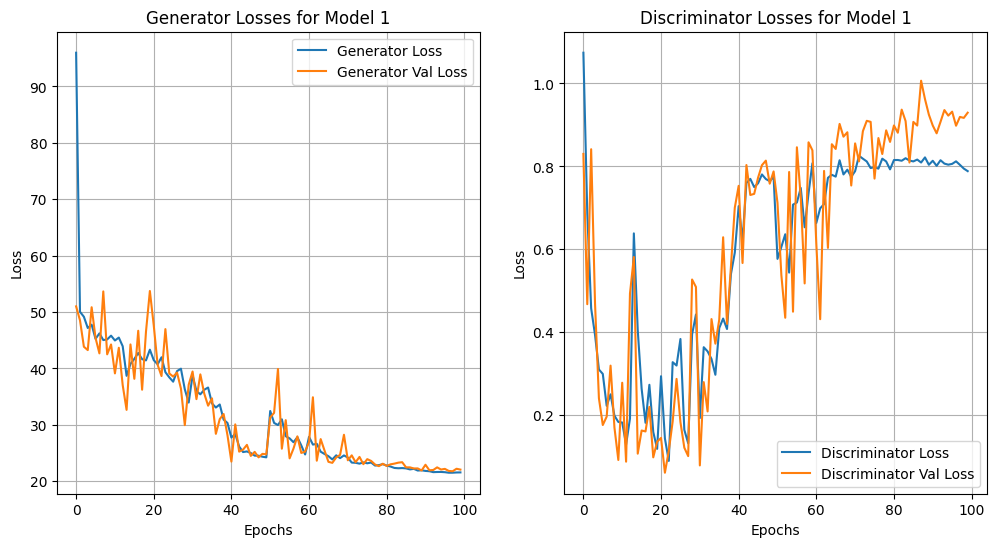

In [ ]:
MODEL_NAME = 'd4_v1_model_1'

history = pickle.load(open(f"saved_models/{MODEL_NAME}/history.pickle", 'rb'))
plot_history(history, 'Model 1') 


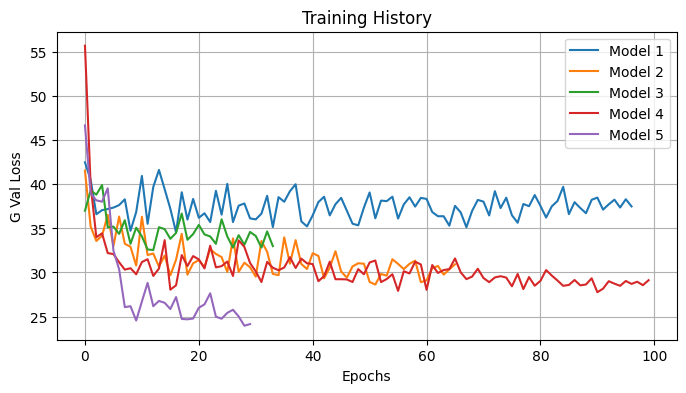

In [4]:
import pickle
import matplotlib.pyplot as plt
import os

def plot_trainings(model_dirs: list):
    plt.figure(figsize=(8, 4))
    plt.title('Training History')

    
    for i, model in enumerate(model_dirs):
        with open(os.path.join(model, 'history.pickle'), 'rb') as f:
            history = pickle.load(f, encoding='latin1')
        plt.plot(history['G']['val_losses'], label=f'Model {i+1}')

    plt.xlabel('Epochs')
    plt.ylabel('G Val Loss')
    plt.legend()
    plt.grid()
    plt.show()


model_dirs = [
    'saved_models/d1_v2_model_3',
    'saved_models/d1_v2_model_4',
    'saved_models/d1_v2_model_5',
    'saved_models/d1_v2_model_6',
    'saved_models/d1_v2_model_7',
]

plot_trainings(model_dirs)


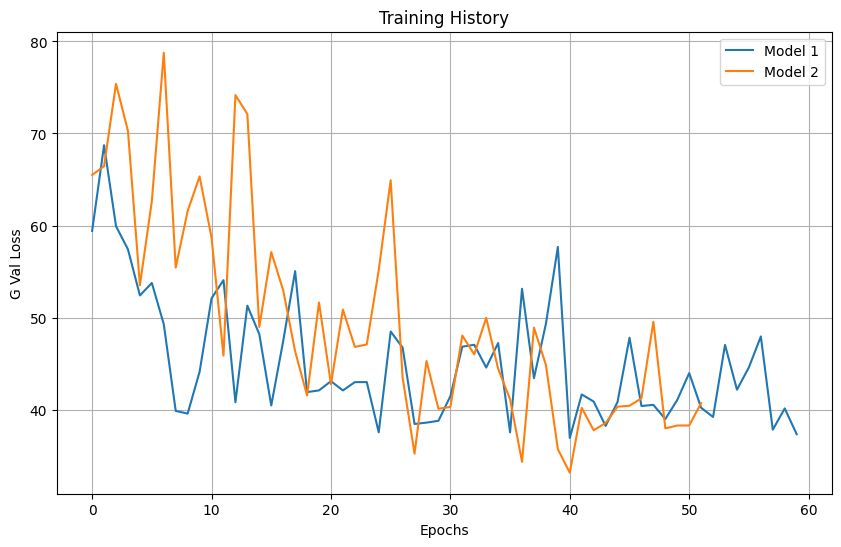

In [ ]:
model_dirs = [
    'saved_models/d2_model_3',
    'saved_models/d2_v1_model_4'
]

plot_trainings(model_dirs)


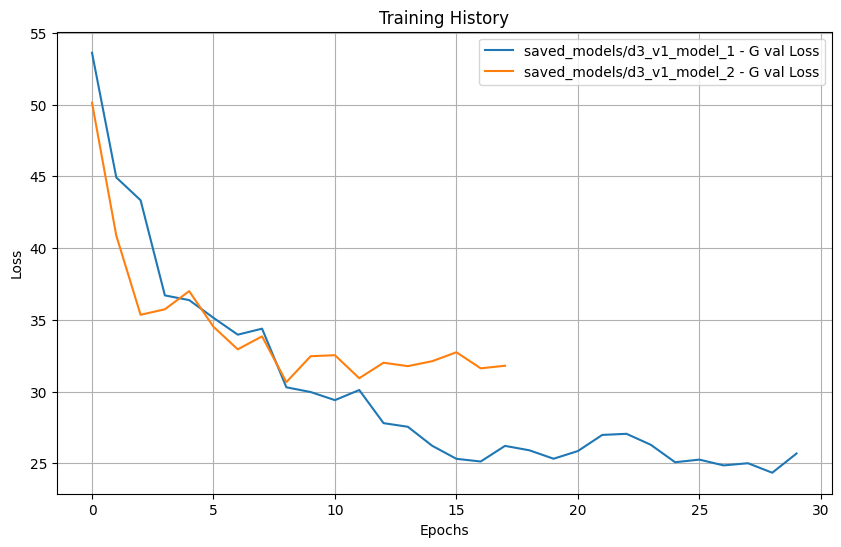

In [6]:
model_dirs = [
    'saved_models/d3_v1_model_1',
    'saved_models/d3_v1_model_2',
]

plot_trainings(model_dirs)

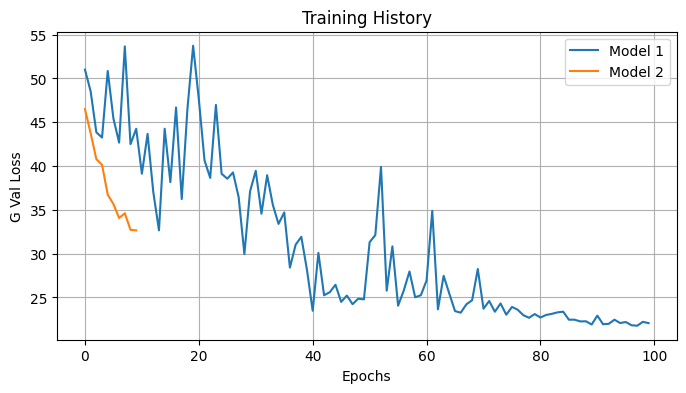

: 

In [ ]:
model_dirs = [
    'saved_models/d4_v1_model_1',
    'saved_models/d7_v1_model_1'
]

plot_trainings(model_dirs)

# Extraer información de los Datasets

In [ ]:
import pickle
source_dir_1 = r'data_source\sing_voices_all'
source_dir_2 = r'data_source\violin'

dataset = r'TFG\datasets\dataset_1\v2'

test_refs = pickle.load(open(fr'{dataset}\refs_train.pickle', 'rb'))
test_data = pickle.load(open(fr'{dataset}\data_train.pickle', 'rb'))

first_line = open(fr'{dataset}\params.txt', 'r').readline().strip()
speakers = eval(first_line.replace('SPEAKERS: ', ''))

data = []
for spkr, refs in test_refs.items():
    for ref in refs:
        if spkr == 0:  # Hablante masculino
            file_path = os.path.join(source_dir_1, ref)
        else:  # Hablante femenino
            file_path = os.path.join(source_dir_2, ref)
        
        duration = librosa.get_duration(filename=file_path)
        data.append({'file': ref, 'speaker': speakers[spkr], 'duration': duration})
sorted_data = sorted(data, key=lambda x: x['file'], reverse=False)
sorted_data[15:]

[{'file': 'AuSep_2_vn_08_Spring.wav', 'speaker': 'violin', 'duration': 35.035},
 {'file': 'AuSep_2_vn_09_Jesus.wav',
  'speaker': 'violin',
  'duration': 198.86533333333333},
 {'file': 'AuSep_2_vn_12_Spring.wav',
  'speaker': 'violin',
  'duration': 130.93079166666666},
 {'file': 'AuSep_2_vn_19_Pavane.wav',
  'speaker': 'violin',
  'duration': 133.3665625},
 {'file': 'AuSep_2_vn_24_Pirates.wav',
  'speaker': 'violin',
  'duration': 49.8164375},
 {'file': 'AuSep_2_vn_25_Pirates.wav',
  'speaker': 'violin',
  'duration': 49.8164375},
 {'file': 'AuSep_2_vn_26_King.wav',
  'speaker': 'violin',
  'duration': 85.18510416666666},
 {'file': 'AuSep_2_vn_27_King.wav',
  'speaker': 'violin',
  'duration': 85.18510416666666},
 {'file': 'AuSep_2_vn_35_Rondeau.wav',
  'speaker': 'violin',
  'duration': 128.19472916666666},
 {'file': 'AuSep_2_vn_37_Rondeau.wav',
  'speaker': 'violin',
  'duration': 128.19472916666666},
 {'file': 'AuSep_2_vn_39_Jerusalem.wav',
  'speaker': 'violin',
  'duration': 119.

In [ ]:
root = r'data_source\read_voices_8'

SPKRS = os.listdir(root)
SPKRS = [os.path.join(root, spkr) for spkr in SPKRS if os.path.isdir(os.path.join(root, spkr))]
data = []

for spkr in SPKRS:
    if not os.path.isdir(spkr):
        continue
    print(f'Processing speaker: {spkr}')
    
    files = os.listdir(spkr)
    durations = 0
    
    for path in files: 
        file_path = os.path.join(spkr, path)
        duration = librosa.get_duration(filename=file_path)
        durations += duration
    data.append({'spkr': spkr.split('\\')[-1], 'num_files': len(files),'mean duration': durations/ len(files)})

data